[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab7_style_transfer.ipynb)

# Style Transfer

In this lab, you will implement the style transfer algorithm proposed by [Gatys et. al. (2016)](https://arxiv.org/pdf/1508.06576.pdf). Your goal is to produce an image that has the high-level content of one image and the low-level style of another.

To perform style transfer, we will use a neural network as a feature extractor to determine style and content features, and we will optimize an image to reach a balance of the chosen style and content. Note that the network does not generate the final image, nor is the network trained at any point in this lab; instead of training network weights, we train the image itself. Through this lab, you will experience another way to use neural networks and see how deep learning can be used to optimize structures other than neural networks.


## Grading standards
Your code will be graded on the following:

* 20% Correct extraction of image statistics
* 35% Correct construction of loss function in a loss class
* 20% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 15% Correct initialization and optimization of image variable
* 10% Awesome looking final image

---

Here's an additional example of style transfer:

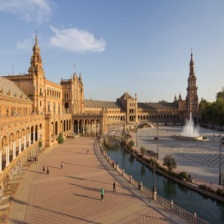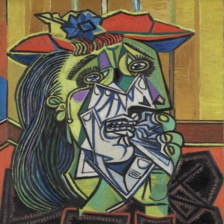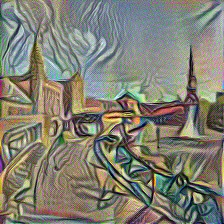

---

In [558]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from tqdm import tqdm
from torch.nn.parameter import Parameter
from PIL import Image
import io

# IF NOT USING COLAB: comment out the following import statement:
# from google.colab import files

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Select two images: one for content and one for style. The images should have noticeably different content and style from each other to make it clear if the style transfer worked.

In [559]:
# Use this code to upload your own images.
# NOTE: if you are not using Colab, `upload()` will not work. Just make sure the images are on your file system and set `content_path` and `style_path` accordingly.

load_and_normalize = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  # file_dict = files.upload()
  content_path = "images/sagrada_familia.jpeg" #io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  # file_dict = files.upload()
  style_path = "images/picasso_landscape.jpeg" # io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image

Upload Style Image
Content Path: images/sagrada_familia.jpeg
Style Path: images/picasso_landscape.jpeg


In [560]:
# Load in and normalize the images
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(content_image_orig).unsqueeze(0).to(device)
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(style_image_orig).unsqueeze(0).to(device)


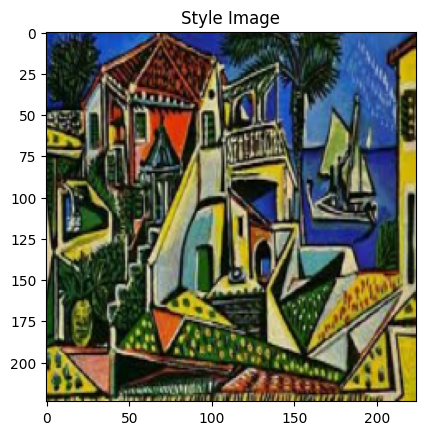

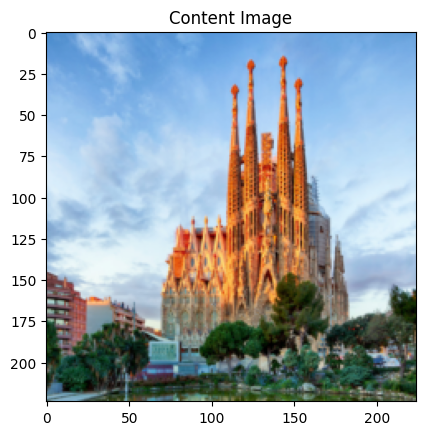

In [561]:
# Display the images
toPIL = transforms.ToPILImage()

def display(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

## Part 1

We will use a pretrained VGG-16 network as a feature extractor to get the style and content statistics from the images.

We provide you with the `VGGIntermediate` class to load in the pretrained model and to grab intermediate layers.



* Correctly initialize a VGGIntermediate object to extract style and content
* Gather content statistics from the outputs of intermediate layers for the content image
* Gather style statistics for the style image

**DONE:**



In [562]:
import torchvision.models as models

# You should not have to change any of the code in the following classes.

# Normalization layer normalizes the image pixels to mean=0 std=1 according to the statistics of the ImageNet training dataset (which the VGG was pretrained on)
class Normalization(nn.Module):
  def __init__(self):
      super(Normalization, self).__init__()
      self.mean = torch.tensor([0.485, 0.456, 0.406]).view(-1, 1, 1).to(device)
      self.std = torch.tensor([0.229, 0.224, 0.225]).view(-1, 1, 1).to(device)

  def forward(self, img):
      return (img - self.mean) / self.std

# Wrapper for the pretrained VGG-16. Instead of returning the output of the VGG, it returns the `requested` layers.
class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # we want to set the relu layers to NOT do the relu in place.
          m.inplace = False          # the model has a hard time going backwards on the in place functions.

        if i in requested:
          # This stores the output of the requested layer as `intermediates[i]`
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))

  def forward(self, x):
    self.vgg(self.norm(x))
    return self.intermediates.copy()

We provide you with the list of VGG-16 layer names. Select the names of the layers you'd like to use to extract the content and style ([Gatys et. al. (2016)](https://arxiv.org/pdf/1508.06576.pdf) has suggestions on which layers to use).

Save the layer indexes (not names) into a list for the `requested` parameter of `VGGIntermediate`.

In [563]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", "conv3_3", "relu3_3","maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", "conv4_3", "relu4_3","maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", "conv5_3", "relu5_3","maxpool5"]

In [564]:
layer_map = {name: idx for idx, name in enumerate(vgg_names)}

In [565]:
content_layers = ['conv4_2']
style_layers = [ "conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

Create a `VGGIntermediate` object, providing it with the intermediate layers. You can use a single network to extract both the content and the style, but be sure to keep track of which layers are which.

In [566]:
content_layer_indices = [layer_map[layer] for layer in content_layers]
style_layer_indices = [layer_map[layer] for layer in style_layers]

requested_layers = content_layer_indices + style_layer_indices

vgg_intermediate = VGGIntermediate(
    requested=requested_layers
).to(device)

Use your `VGGIntermediate` network to extract the content from `content_image` and the style from `style_image`. Save these tensors: they will be used throughout training! Be sure to detach these tensors, since these are our labels and we don't want to backpropagate with respect to them.

In [567]:
content_indices_set = set(content_layer_indices)
style_indices_set = set(style_layer_indices)

content_image = content_image.to(device)
style_image = style_image.to(device)

content_features = vgg_intermediate(content_image)
content_targets = {layer: content_features[layer].detach() for layer in content_layer_indices}

style_features = vgg_intermediate(style_image)
style_targets = {layer: style_features[layer].detach() for layer in style_layer_indices}

---

## Part 2

The loss functions are key to learning the correct behavior in any machine learning problem. For style transfer, we have two losses: content loss and style loss. Our final loss is a combination of both to provide a balance between these competing objectives.

Show that you understand style transfer by describing the key equations of [Gatys et al. 2016](https://arxiv.org/pdf/1508.06576.pdf) in your own words. You may need to read the surrounding sections to understand the equations.

Content Loss:

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English. Include the meaning of all variables and what each dimension represents for each matrix and vector variable.

$\mathcal{L}_{content}(\vec{p}, \vec{x}, l) = \frac{1}{2}\sum_{i,j} (F^l_{ij} - P^l_{ij})^2$

Plain english: The sum of squared errors between the feature representations of the generated image and the original image.

$\mathcal{L}_{content}$: Content loss between the two images
 
$\mathcal{\vec{p}}$: original image

$\mathcal{\vec{v}}$: generated image

$\mathcal{l}$: prospective layer of images

$\mathcal{F^l_{i,j}}$: the activation of the ith filter at position j

$\mathcal{P^l_{i,j}}$: feature representation of original image

Style Loss:

- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and what each dimension represents for each matrix and vector variable (including the output).

$G^l_{ij} = \sum_k F^l_{ik} F^l_{jk}$

Plain english: Vectorized dot product between two feature representations that creates the correlation between two feature maps.

$G^l_{ij}$: Gram matrix representing correlations between two feature maps

$F^l_{ik}$ the activation of the ith filter at position k

$F^l_{jk}$ the activation of the jth filter at position k


- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and what each dimension represents for each matrix and vector variable.

$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j} (G^l_{ij} - A^l_{ij})^2$

Plain english: the mean-squared distance between the entries of the Gram matrix from the original image and the Gram matrix of the image to be generated

$E_l$: Mean squared distance between two gram matrices

$G^l_{ij}$: Style representation of generated image of the ith filter at position j

$A^l_{ij}$: Style representation of original image of the ith filter at position j

$N_l$: Number of distinct filters and number of feature maps in the layer

$M_l$: Height times width of the feature map


- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.

$\mathcal{L}_{style}(\vec{a}, \vec{x}) = \sum^L_{l=0} w_lE_l$

Plain english: Total style loss of the network

$\mathcal{L}_{style}$: Total style loss of the network

$\vec{a}$: Original image vector

$\vec{x}$: Generated image vector

$w_l$: Weighting factor of each layers contribution to loss.

$E_l$: Mean squared distance between two gram matrices


___

## Part 3
Now that you understand the loss functions mathematically, create modules that calculate the content and style loss for a single content or style layer.

Since the targets will be static throughout learning (the content and style images don't change, nor the network), we can store them in the loss module objects, so we don't have to pass them into the forward each time.

In [568]:
# Produces a gram matrix from a 4D tensor input
def gram_matrix(F):
    N, C, H, W = F.shape  
    F = F.view(C, -1)  
    G = torch.mm(F, F.t()) 
    return G  

# Represents the content loss function for a single content layer
class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()

    def forward(self, y_hat):
        return 0.5 * torch.sum((y_hat - self.target) ** 2)

# Represents the style loss function for a single style layer
class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target_gram = gram_matrix(target).detach()
        N, C, H, W = target.shape
        self.norm_factor = 4 * (C ** 2) * (H * W) ** 2  # Correct denominator

    def forward(self, y_hat):
        y_hat_gram = gram_matrix(y_hat)
        return torch.sum((y_hat_gram - self.target_gram) ** 2) / self.norm_factor

# Instantiate a content loss module for each content layer
#  with the content reference image outputs for that layer for comparison

content_losses = [ContentLoss(image) for layer, image in content_targets.items()]

# Instantiate a style loss module for each style layer
#  with the style reference image outputs for that layer for comparison
style_losses = [StyleLoss(image) for layer, image in style_targets.items()]


Now that you have a list of loss modules, write a loss function that computes the combined style transfer loss. You can weight the overall content and style losses, as well as weighting each layerwise loss value.

Return the combined loss as a tensor for learning. Return the content and style loss values for plotting.

In [569]:
def combined_style_transfer_loss(y_hat, content_loss_modules=content_losses, style_loss_modules=style_losses, alpha=1, beta=1e6):
    y_hat_features = vgg_intermediate(y_hat)

    content_features = {layer: y_hat_features[layer] for layer in content_layer_indices}
    style_features = {layer: y_hat_features[layer] for layer in style_layer_indices}

    total_content_loss = sum(content_loss(content_features[layer]) for content_loss, layer in zip(content_loss_modules, content_layer_indices))
    total_style_loss = sum(style_loss(style_features[layer]) for style_loss, layer in zip(style_loss_modules, style_layer_indices))

    total_loss = alpha * total_content_loss + beta * total_style_loss

    return total_loss, total_content_loss.item(), total_style_loss.item()


___

## Part 4
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

**TODO:**

* Use an Adam optimizer (try learning rate of .1, but feel free to experiment)
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!
* Experiment with different hyperparameters or network layers until you're satisfied with your final image

**DONE:**



First, we need to define our image. While we can create a random image and hope that the optimization works, the best results come from using a clone of the content image. That way, the image starts with the desired content and the content loss only needs to preserve the existing content.

Create a clone of the content image as your initial "generated" image. Calculate and print content and style loss (separately) for your generated image. What do you notice about these losses? Make sure the losses match what you'd expect, given that the generated image is a copy of the content image.

In [570]:
generated_image = content_image.clone().to(device)

In [571]:
total, content, style = combined_style_transfer_loss(generated_image, content_losses, style_losses)

In [572]:
print(f"Content: {content}, Style: {style}")

Content: 0.0, Style: 17184.76953125


The content loss is zero while the style loss is enormous! This is because the generated image is the content image, and has nothing in common with the style image.

Prepare your generated image for optimization. You need two things:


1.   Your generated image must require gradients: set requires_grad to true by setting the object parameter `requires_grad` or calling the function `requires_grad_()`.
2.   Create an optimizer with your generated image as the parameter. Torch optimizers expect a list of parameters (or tensors), so you'll need to wrap your generated image in a single-item list for the optimizer.



In [573]:
# Prepare your generated image to learn
generated_image.requires_grad_(True)

# Create your optimizer: we suggest starting using an Adam optimizer with lr=.1
optimizer = optim.Adam([generated_image], lr=.1)

Now create and run your training loop, storing content and style losses as you train. Remember, you will be optimizing the **generated image** according to the content and style statistics extracted with the network. Print your final image.

For best results, use `torch.clamp(generated_im, 0, 1)` to keep your pixel values in range after each learning step.

Style transfer is very susceptible to overtraining, which introduces a lot of noise to the final image. Print your image often during the training process to find the best-looking image.

In [574]:
def tensor_to_image(tensor):
    transform = transforms.ToPILImage()
    return transform(tensor.cpu().squeeze(0))

def display_image(tensor):
    image = tensor_to_image(tensor)
    plt.imshow(image)
    plt.show()

def run(generated_image, loss_function, optimizer, num_steps=500, print_interval=50, lr=0.1):
    total_losses = []
    content_losses = []
    style_losses = []
    for step in range(1, num_steps + 1):

        if step == 1 or step % print_interval == 0:
            display_image(generated_image)

        optimizer.zero_grad()

        total_loss, content_loss, style_loss = loss_function(generated_image)
        
        total_losses.append(total_loss)
        content_losses.append(content_loss)
        style_losses.append(style_loss)

        total_loss.backward()
        optimizer.step()

        with torch.no_grad():
            generated_image.data = torch.clamp(generated_image.data, 0, 1)

        if step == 1 or step % print_interval == 0:
            print(f"Step {step}: Content Loss = {content_loss:.4f}, Style Loss = {style_loss:.4f}")

    return total_losses, content_losses, style_losses

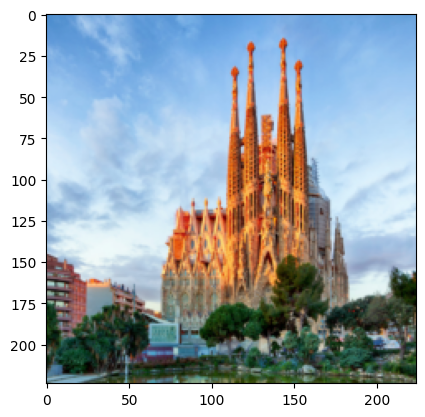

Step 1: Content Loss = 0.0000, Style Loss = 17184.7695


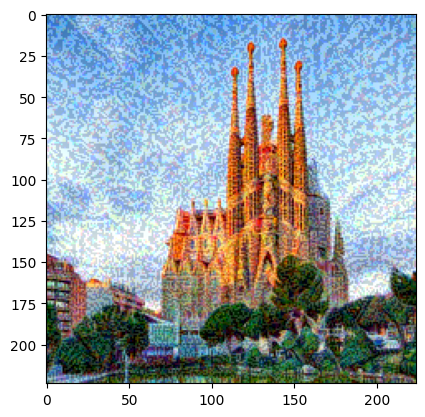

Step 2: Content Loss = 10826303.0000, Style Loss = 13067.5166


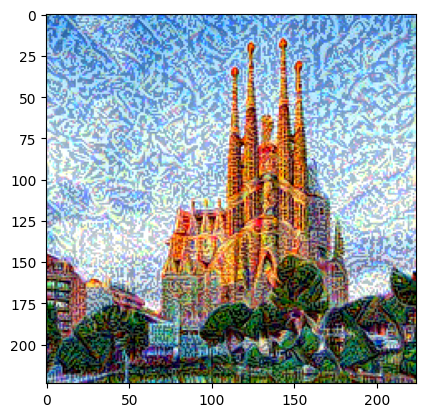

Step 3: Content Loss = 38357392.0000, Style Loss = 12145.2715


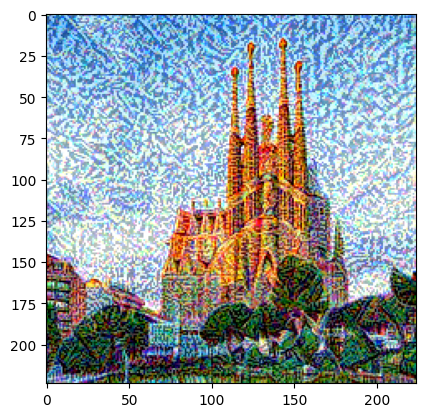

Step 4: Content Loss = 15847726.0000, Style Loss = 13122.6973


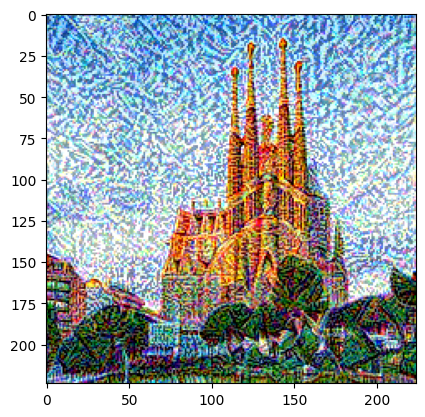

Step 5: Content Loss = 19716556.0000, Style Loss = 12117.8672


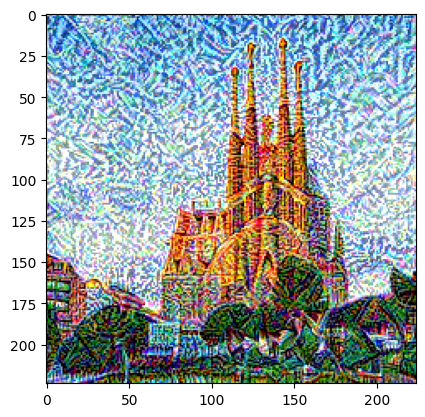

Step 6: Content Loss = 29172526.0000, Style Loss = 10350.0293


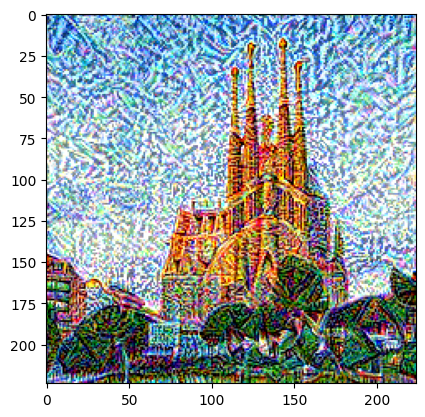

Step 7: Content Loss = 34052316.0000, Style Loss = 10264.6035


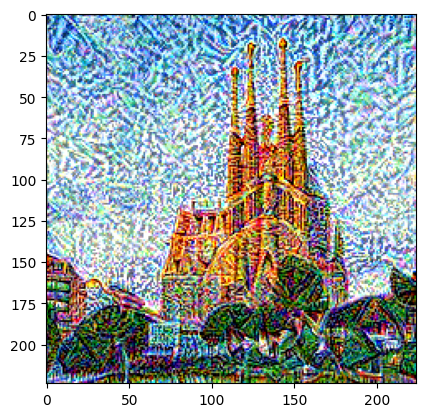

Step 8: Content Loss = 29988970.0000, Style Loss = 8952.8369


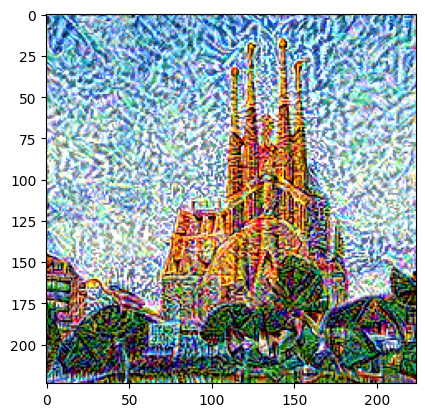

Step 9: Content Loss = 28112108.0000, Style Loss = 8357.1104


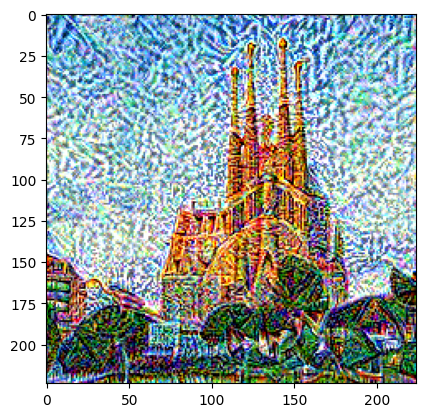

Step 10: Content Loss = 30172356.0000, Style Loss = 7158.0054


In [575]:
total_losses, content_losses, style_losses = run(generated_image, combined_style_transfer_loss, optimizer, num_steps=10, print_interval=1)

Plot your content and style losses. Content loss should start at 0 and increase as style loss decreases. They should both reach an equilibrium.

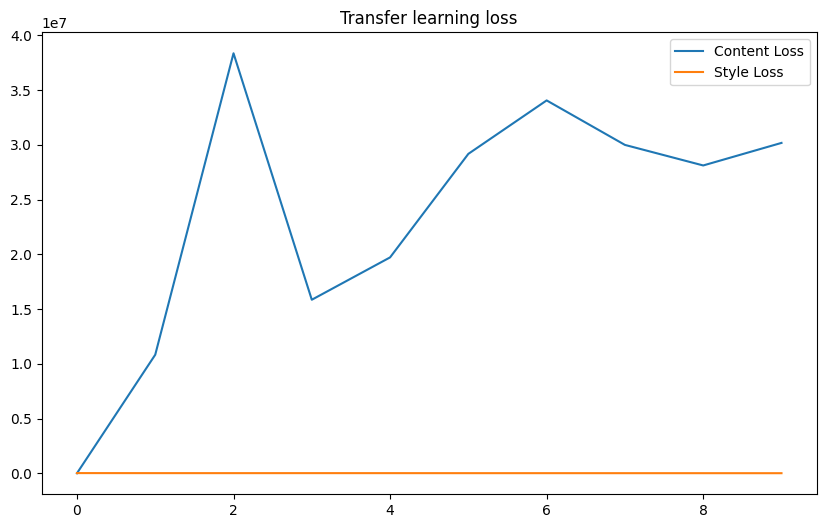

In [576]:
plt.figure(figsize=(10, 6))
plt.plot(content_losses, label='Content Loss')
plt.plot(style_losses, label="Style Loss")
plt.title("Transfer learning loss")
plt.legend()
plt.show()

Now that you have style transfer working, the results may not look very appealing. Different content and style images require different hyperparameters, so you should play around with different network layers, learning rates, and loss weighting to get the best results.